In [2]:
import pandas as pd
import numpy as np
import geopandas
import geopy
from geopy.geocoders import Nominatim
from geopy import distance
from geopy.extra.rate_limiter import RateLimiter
from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
properties_df = pd.read_csv("properties-susquehannavalley2020MAR29.csv",index_col=0)

In [5]:
properties_df = properties_df[properties_df['list-card-type']!="Lot / Land for sale"]
properties_df = properties_df[properties_df['list-card-type']!="New construction"]
properties_df = properties_df[properties_df['list-card-type']!="Apartment for sale"]

In [6]:
properties_df['list-card-price'] = properties_df['list-card-price'].str.replace("\$|,|\+|-|Est| ",'')

In [7]:
properties_df['list-card-price'] = pd.to_numeric(properties_df['list-card-price'])

In [8]:
properties_df['beds'] = properties_df['list-card-details'].str.extract("(.+) bds")
properties_df['beds'] = properties_df['beds'].str.replace('--','')
properties_df['beds'] = pd.to_numeric(properties_df['beds'])

In [9]:
properties_df['baths'] = properties_df['list-card-details'].str.extract("bds(.+) ba")
properties_df['baths'] = properties_df['baths'].str.replace('--','')
properties_df['baths'] = pd.to_numeric(properties_df['baths'])

In [10]:
properties_df['floorspace'] = properties_df['list-card-details'].str.extract("ba(.+) sqft")
properties_df['floorspace'] = properties_df['floorspace'].str.replace(',','')
properties_df['floorspace'] = properties_df['floorspace'].str.replace('--','')
properties_df['floorspace'] = pd.to_numeric(properties_df['floorspace'])

In [11]:
properties_df['street'] = properties_df['list-card-addr'].str.extract("[0-9]+ (.+) ")

In [12]:
street_df = properties_df['street'].str.split(',',n=2,expand=True)
street_df.columns=pd.Index(['street_name','city','state'])
properties_df = properties_df.join(street_df)

In [13]:
locator_Nominatim = geopy.Nominatim(user_agent="myGeocoder")
olin_science=locator_Nominatim.geocode("Olin Science, Vaughan Lit Drive, College Park, Union County, PA, 17837")

In [14]:
buckenell_math_lat_long=tuple(olin_science.point)[:2]
buckenell_math_lat_long

(40.955516450000005, -76.88276067249578)

In [15]:
locator_ArcGIS = geopy.ArcGIS(user_agent="myGeocoder")
locator_ArcGIS.geocode("614 Maclay Ave, Lewisburg, PA 17837")

Location(614 Maclay Ave, Lewisburg, Pennsylvania, 17837, (40.96913573910785, -76.89508247833125, 0.0))

In [16]:
geocode_Nominatim_rate_limited = RateLimiter(locator_Nominatim.geocode, min_delay_seconds=1)
geocode_ArcGIS_rate_limited = RateLimiter(locator_ArcGIS.geocode, min_delay_seconds=1)

In [17]:
properties_df['location_ArcGIS'] = properties_df['list-card-addr'].apply(geocode_ArcGIS_rate_limited)

RateLimiter caught an error, retrying (0/2 tries). Called with (*('37 Parkridge Dr, Selinsgrove, PA 17870',), **{}).
Traceback (most recent call last):
  File "/usr/lib/python3.8/urllib/request.py", line 1317, in do_open
    h.request(req.get_method(), req.selector, req.data, headers,
  File "/usr/lib/python3.8/http/client.py", line 1230, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/usr/lib/python3.8/http/client.py", line 1276, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/usr/lib/python3.8/http/client.py", line 1225, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/usr/lib/python3.8/http/client.py", line 1004, in _send_output
    self.send(msg)
  File "/usr/lib/python3.8/http/client.py", line 944, in send
    self.connect()
  File "/usr/lib/python3.8/http/client.py", line 1399, in connect
    self.sock = self._context.wrap_socket(self.sock,
  File "/usr/lib/python3.8

RateLimiter caught an error, retrying (0/2 tries). Called with (*('375 Mill Rd, Selinsgrove, PA 17870',), **{}).
Traceback (most recent call last):
  File "/usr/lib/python3.8/urllib/request.py", line 1317, in do_open
    h.request(req.get_method(), req.selector, req.data, headers,
  File "/usr/lib/python3.8/http/client.py", line 1230, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/usr/lib/python3.8/http/client.py", line 1276, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/usr/lib/python3.8/http/client.py", line 1225, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/usr/lib/python3.8/http/client.py", line 1004, in _send_output
    self.send(msg)
  File "/usr/lib/python3.8/http/client.py", line 944, in send
    self.connect()
  File "/usr/lib/python3.8/http/client.py", line 1399, in connect
    self.sock = self._context.wrap_socket(self.sock,
  File "/usr/lib/python3.8/ssl

In [25]:
properties_df['location_ArcGIS'].apply(lambda loc: loc.latitude if 'latitude' in dir(loc) else np.nan)

0      40.962949
1      41.053239
2      40.859539
3      40.827991
4      40.952689
         ...    
791    40.798709
792    40.852694
794    40.831827
796    40.793713
798    41.101373
Name: location_ArcGIS, Length: 654, dtype: float64

In [27]:
properties_df['latitude']=properties_df['location_ArcGIS'].apply(lambda loc: loc.latitude if 'latitude' in dir(loc) else np.nan)
properties_df['longitude']=properties_df['location_ArcGIS'].apply(lambda loc: loc.longitude if 'longitude' in dir(loc) else np.nan)
properties_df['point']=properties_df['location_ArcGIS'].apply(lambda loc: (loc.latitude,loc.longitude) if 'longitude' in dir(loc) else (np.nan,np.nan))

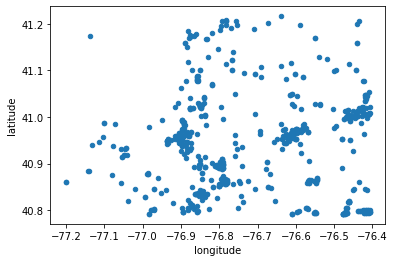

In [28]:
properties_df.plot.scatter(x='longitude',y='latitude')

In [31]:
def distance_to_math(location):
    try:
        return distance.distance(location, buckenell_math_lat_long).miles
    except:
        return np.nan

In [32]:
properties_df['distance_to_math_dept'] = properties_df['point'].apply(distance_to_math)

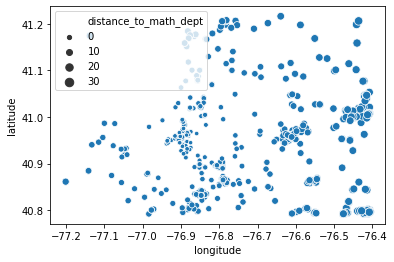

In [33]:
sns.scatterplot(data=properties_df,x='longitude',y='latitude',size='distance_to_math_dept')

In [34]:
properties_df.to_csv("properties-susquahannavalley-enriched2020MAR29.csv")